In [1]:
import torch
from torchvision import transforms
from model import UNet
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm

In [2]:
device = 'mps'
image_size = (32, 32)

# Diffusion Model

## Forward Diffusion Process

Given a real-world image $x_0 \sim q(x)$, we define a forward diffusion process which adds a small amount of Gaussian
noises to $x_0$ until time step $T$. With this process, we will produce a sequence of noiser and noiser version of
$x_0: (x_0, x_1, \dots, x_T)$. How large the noise is in each step is controlled by hyperparamters $\beta_t, t = 1, 2,
\dots, T$. Given a noisy image at step $t-1$, the new noisy image follows the following Gaussian distribution:
$$
q(x_t | x_{t - 1}) = \mathcal{N}(x_t; \sqrt{1 - \beta_t}x_{t-1}, \beta_tI)
$$
By the product role,
$$
q(x_t | x_0) = \prod_{t=1}^T q(x_t | x_{t-1}).
$$
A nice property allows use to sample $x_t$ given $x_0$ without calculating the intermediate steps. Let $\alpha_t = 1 -
\beta_t$, then
$$
\begin{align*}
x_t &= \sqrt{\alpha_t} x_{t - 1} + \sqrt{1 - \alpha_t} \epsilon_{t - 1}, \text{ where } \epsilon_{t - 1} \sim
\mathcal{N}(0, I) \\
    &= \sqrt{\alpha_t \alpha_{t - 1}} x_{t - 1} + \sqrt{1 - \alpha_t \alpha_{t - 1}} \bar{\epsilon}_{t - 2} \\
    &= \cdots \\
    &= \sqrt{\bar{\alpha_t}}x_0 + \sqrt{1 - \bar{\alpha_t}}\epsilon
\end{align*}
$$

## Reverse Diffusion Process

If we can sample from $q(x_{t-1}|x_t)$, then we can reconstruct $x_0$ from $x_T$, which follows $\mathcal{N}(0, I)$.
Since it is difficult to estimate this distribution, we use parametric function, such as a neural network, to
approximate this conditional probability in order to achieve the goal of reconstruction.

In [3]:
class DiffusionModel:
    def __init__(self, start_schedule=0.0001, end_schedule=0.02, timesteps=300):
        self.start_schedule = start_schedule
        self.end_schedule = end_schedule
        self.timesteps = timesteps
        self.betas = torch.linspace(start_schedule, end_schedule, timesteps)
        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)

    def forward(self, x_0, t, device):
        noise = torch.randn_like(x_0)
        sqrt_alphas_cumprod_t = self.get_index_from_list(
            self.alphas_cumprod.sqrt(), t, x_0.shape
        )
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(
            torch.sqrt(1.0 - self.alphas_cumprod), t, x_0.shape
        )

        mean = sqrt_alphas_cumprod_t.to(device) * x_0.to(device)
        variance = sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device)

        return mean + variance, noise.to(device)

    @torch.no_grad()
    def backward(self, x, t, model, **kwargs):
        betas_t = self.get_index_from_list(self.betas, t, x.shape)
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(
            torch.sqrt(1.0 - self.alphas_cumprod), t, x.shape
        )
        sqrt_recip_alphas_t = self.get_index_from_list(
            torch.sqrt(1.0 / self.alphas), t, x.shape
        )
        mean = sqrt_recip_alphas_t * (
            x - betas_t * model(x, t, **kwargs) / sqrt_one_minus_alphas_cumprod_t
        )
        posterior_variance_t = betas_t

        if t == 0:
            return mean
        else:
            noise = torch.randn_like(x)
            variance = torch.sqrt(posterior_variance_t) * noise
            return mean + variance

    @staticmethod
    def get_index_from_list(values, t, x_shape):
        batch_size = t.shape[0]
        """
        pick the values from vals
        according to the indices stored in `t`
        """
        result = values.gather(-1, t.cpu())
        """
        if 
        x_shape = (5, 3, 64, 64)
            -> len(x_shape) = 4
            -> len(x_shape) - 1 = 3
            
        and thus we reshape `out` to dims
        (batch_size, 1, 1, 1)
        
        """
        return result.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [4]:
def forward_diffusion(x0, t, betas=torch.linspace(0.0, 1.0, 5)):
    alphas = 1 - betas
    alphas_bar = torch.cumprod(alphas, dim=0)
    alphas_bar_t = alphas_bar.gather(axis=-1, index=t).reshape(-1, 1, 1, 1)

    noise = torch.rand_like(x0)
    mean = alphas_bar_t.sqrt() * x0
    variance = torch.sqrt(1 - alphas_bar_t) * noise
    return mean + variance, noise

In [5]:
def get_ramya():
    import urllib.request
    from PIL import Image
    url = "https://ramyakv.github.io/RamyaVinayak2.jpg"
    filepath = "image.jpg"
    urllib.request.urlretrieve(url, filepath)
    image = Image.open(filepath)
    return image

In [6]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x * 2 - 1)
])
reverse_transform = transforms.Compose([
    transforms.Lambda(lambda x: (x + 1) / 2),
    transforms.Lambda(lambda x: x.permute(1, 2, 0)),
    transforms.Lambda(lambda x: x * 255.),
    transforms.Lambda(lambda x: x.numpy().astype(np.uint8)),
    transforms.ToPILImage(),
])

In [7]:
pil_image = get_ramya()
torch_image = transform(pil_image).to(device)

In [8]:
diffusion_model = DiffusionModel()

In [9]:
unet = UNet(
    T=300,
    ch=128,
    ch_mult=[1, 2, 3, 4],
    attn=[2],
    num_res_blocks=2,
    dropout=0.15,
).to(device)

NO_EPOCHS = 1000
PRINT_FREQUENCY = 10
LR = 0.001
BATCH_SIZE = 128

optimizer = torch.optim.Adam(unet.parameters(), lr=LR)

In [10]:
losses = []

for epoch in tqdm(range(NO_EPOCHS)):
    batch = torch.stack([torch_image] * BATCH_SIZE)
    t = torch.randint(0, diffusion_model.timesteps, (BATCH_SIZE, )).long().to(device)
    noisy_image, gt_noise = diffusion_model.forward(batch, t, device)
    predicted_noise = unet(noisy_image, t)

    optimizer.zero_grad()
    loss = torch.nn.functional.mse_loss(predicted_noise, gt_noise)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

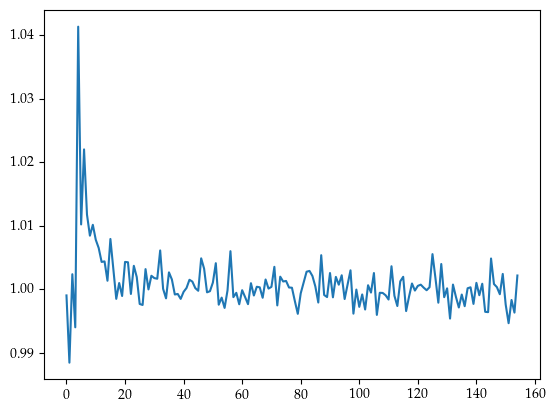

In [11]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(losses)), losses)
plt.show()